#Movie Matching System#

#####Which movie is this scene from?#####
<img src="http://2.bp.blogspot.com/-ip-SIVBkwfM/TaaJHL6VPmI/AAAAAAAAMVU/3LGPMETvc5M/s1600/the-godfather-mafia-movie.png" width=480/>


In this project, we aims to design a system that could identify a short clip from a movie and match the clip to the original movie among a large movie database.

####Method####

We researched multiple ways this matching could be done, and came across a paper by Wang et al. on the Shazam system, a music matching software that has proven to be efficient and reliable. We implemented a similar algorithm to match the soundtrack of the clip to the soundtrack of the underlying movie. In our case, movies are much longer than songs, so computation techniques that makes the matching go faster are particularly valuable.

Shazam paper: http://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf

Here is a quick overview of how Shazam works:
Any soundtrack is first converted to a 2D map, where the most distinguishable sounds are marked (in the graph below). We use the amplitude of the sound to be the filter, and extract the only time and frequencies of the loudest sounds. This way, the amount of data need to be stored and computed decrease dramatically.
<img src="files\fp_peaks.png" width=480/>
To store the reduced data, Shazam utilized a "hash" structure. With a pre-defined "window", Shazam computes the difference between the time a sound occurs and each of the later sound that is included in the window. This sound is thereafter (not uniquely) identified as the combination of the frequencies of the two sounds and the time-offset, which we call the "hash". With storing the time that the first sound occurs as an additional variable, now we can construct a set of (hash, t1) pairs, which should be drastically different between two different songs. This set of hash pairs are the fingerprints.
<img src="files\fp_hash.png" width=480/>
To match a clip to a soundtrack, we would need to generate the fingerprints for botht the clip and the soundtrack. Then the hashes are compared, and due to the fact that the clip may start from the middle of the movie, there is usually a fixed difference in the t1 values of the matched hashes. We put the differences in t1 values into 200 buckets, and the most frequent t1 difference is then identified as the best estimate of when from the movie is the clip being recorded, and the count of the most frequent t1 differences is an idicator of the goddness of match. When this count is compared across all soundtracks that are compared to a clip, the soundtrack with the highest count of same t1 offsets is chosen as our system's best guess of where the clip comes from.
<img src="files\fp_hist.png" width=480/>

####Data####

We downloaded the 17 soundtracks from the Godfather trilogy, which contains background music across three movies with similar use of music style and instruments. The total size is 592MB and the soundtracks are about one hour long with extremely high quality .wav formats. There is no voice talking over the music, which makes it additionally difficult for our algorithm, as human voice is one of the most distinguishable sounds in our fingerprints. We believe this way we will get a baseline accuracy for our system.

Excerpts are made by functions in this notebook to directly cut a 5 second sample from each original soundtrack, and recordings are made by playing each soundtrack for 5 seconds and 10 seconds, while using another recording function in this notebook to record the clip from another computer. There are background noises for the recordings.

####Instruction####

This notebook is ready to be run through. Note that I have already put the excerpts and recordings as well as the fingerprints in the data folder, which needs to be in the same directory as the notebook. Feel free to re-run all of them, except for the recordings because it's a manual process. I have commented out the code for the recording part. I would expect to see similar results on any machines, and a full run-through should take about 30 minutes, most of which is spent on reading the original soundtracks into fingerprints (which you can skip). Key statistics will be printed out immediately following the execution.


####Performance####
<img src="files\results.png" width=960/>
We are glad to see that we achieved speedup in both paralellizations.
1. Make fingerprints with multiprocessing
By applying multiprocessing, we did accomplish a 2x speedup with 4 cores. This is less than linear, which I think is mainly due to overhead costs. We used htop to ensure that all cores are utilized during the run:
<img src="files/htop.png"/>

2. Match hashkeys with OpenCL
Using OpenCL, the overall time spent on searching 18 excerpts/recordings over 18 original soundtracks decreased slightly (x0.9). We thing the major costs come from arrays and variables being passed into the kernal. However, if we only time the matching process, we achieved significant speedup, at 600-800 times faster, while maintaining similar levels of accuracy. This is exciting, because as the database scale and in the real life when only 1 clip will be searched to much longer soundtracks, the matching process will take up more weight in the computation time, and the soundtracks' fingerprints won't need to be passed into repetively (which seems to be the case here). Therefore, our speedup is very scalable, and we expect the total time to decrease significantly comparing to the serial scenario when the original soundtracks grow much larger.

In terms of accuracy, both serial and parallel versions achieved a 100% accuracy when the excerpts are matched, which is expected because there is no noise nor deletion in the sound data. When matching recorded clips, both the serial and parallel version are relatively accurate, especially given the fact that there is no human voice and some of the pieces in our database are really similar. We observe that increasing the length of the excerpt did manage to improve accuracy in the parallel scenario, without incurring much extra time.


####Design####

There are two parts of the design:
1. Algorithm
Before we applied the Shazam-like algorithm, we were using a much less efficient method (byte difference) to compare two soundtracks. This method not only produces huge datafiles to be stored, but is also generally slow.
After switching to the hash structure, we were able to get more than 10x speedup, and only need to store less than 5% of the original files.

2. Parallelism
We chose to use multiprocessing to parallelize the finger creation process, because of several reasons:
- This is a one time process. Once the data is read in, it is stored and does not need reloading. Therefore, resources should be spent toward the matching part, and multiprocessing is a simple and effective (2x speedup) solution.
- Several python libraries were used in the process, which makes it hard to get into the package and customize the code (like for Cython).

On the other hand, we decided to explore OpenCL as the tool to parallelize the matching process, as utilizing GPU would speed up the process significantly (700x). Here are some of the details of our OpenCL design:
- Instead of passing the list of (hash, [t1, t2, ...]) tuples into the matching function, we needed to pass fixed-length items and decided to instead pass [(hash, t1), (hash, t2), ...] into the kernal. This step was done outside of the matching function, and takes roughly the same amount of time comparing to making fingerpy rints that are fed into the serial code.
- Another challenge was that in parallel we need to build the "bucket" list, which stores the number of t1 offsets that fall into a particular range. Due to the fixed-length constrained, we split the whole soundtrack time into 200 equally sized buckets, and use a counter to keep track of corresponding number of matches.

####Next Steps####

There are a few simple functionalities we would like to add to the code but didn't have time to get to:
- The ability to tell what time the excerpt/clip starts in the original movie. This would be a very helpful function, which generally not valuable in song matching.
- We also want to test our methodology on clips where there is no background music but only human speaking, as this is an often scenario for clips people are searching for.
- We would like to explore ways that would decrease the overhead when passing variables into OpenCL. This is currently the bottle neck for better results under the same settings

####Reflection####

I really enjoyed this project because of the iterative process that we explored through, from deciding on the serial algorithms to deciding on the parallelism methodologies. Here we are really thankful for Ray, who spent a lot of time sitting with us challeging our thinking and pushing us to work on interesting tasks.

In this project, the initial designing of the system took a lot of time, which left the room for parallelization short of ideal. This is personally my first software project, and I have learned a lot about design thinking and basic computer engineering knowlegde from the professors, TFs and my teammate. What applies to the future will be the mindset of planning on a high level and setting priorities so the time would be spent on the most significant improvement.

In [1]:
%pylab inline
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter # for finding the peaks in the spectrogram
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure)
from pydub import AudioSegment # for reading wav file.
import hashlib # for generating hash from the frequency and time information
import difflib
import types
import pickle
import time

Populating the interactive namespace from numpy and matplotlib


/Users/fqian/anaconda/lib/python2.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Here we define a function called readAudioFile to read the **wav** file.
- filename specifies the directory of the wav file 
- limit is the number of seconds from the beginning of the song we would like to read. If *limit* is None, readAudioFile returns the data for the whole song. 

In [2]:
def readAudioFile(filename, limit= None):
    audiofile = AudioSegment.from_wav(filename)
    if limit:
        audiofile = audiofile[:limit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels])        
    return channels, audiofile.frame_rate, audiofile

Identify the amplitude peaks within each song, and extract and visualize the frequency and time where the peaks occur.
- Here we use **maximum_filter** function to identify peaks in the neighborhood.
- Then **amp_min** is passed to set the minimum amplitude as the criteria for all the peaks identified in the previous step.
- Finally, a visualization is shown if **plot** is set to be true. The black marks indicate local peaks.

In [3]:
def get_2D_peaks(arr2D, plot, amp_min = 10):
    struct   = generate_binary_structure(2,1)
    neighborhood  = iterate_structure(struct, 20)
    detected_peaks = maximum_filter(arr2D, footprint  = neighborhood) == arr2D
    amps = arr2D[detected_peaks]
    j,i  = np.where(detected_peaks) 
    amps = amps.flatten()
    peaks = zip(j,i, amps)
    peaks_filtered = [x for x in peaks if x[2]>amp_min]
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]
    if plot: 
        fig, ax = plt.subplots(figsize = (24,16))
        ax.imshow(arr2D)
        ax.scatter(frequency_idx, time_idx, color='black')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.axis('tight')
    return zip(frequency_idx, time_idx)

Here we construct a "hash" structure detailed in the Shazam paper. We utilized the hashlib.shal function to concatenate a string containing the following structure:
(freq1+freq2+t_dalta, t1) 
- **freq1**: frequency of the first peak
- **freq2**: frequency of the second peak
- **t_dalta**: the time offset between the first and second peak

Note: freq1, freq2 and t_dalta are stored as hexadecimals to be fixed-lengths for storage and OpenCL purposes
- **t1**: the time when the first peak occurs in the soundtrack


This string is calculated and stored if the second peak is within the window of the first peak, whose length is defined in the wrapper below.

In [4]:
def generate_hashes(peaks, fan_value = 10, len_hash = 25):
    fingerprinted = set()  
    for i in range(len(peaks)):
        for j in range(fan_value):
            if (i + j) < len(peaks) and not (i, i + j) in fingerprinted:
                freq1 = peaks[i][1]
                freq2 = peaks[i + j][1]
                t1 = peaks[i][0]
                t2 = peaks[i + j][0]
                t_delta = t2 - t1
                if t_delta >= 0:
                    h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta))) 
                    yield (h.hexdigest()[0:len_hash], t1)
                fingerprinted.add((i, i + j))

The **fingerprint** function is a wrapper that calls get_2D_peaks and generate hashes with key parameters passed into the calculations.

Here are the standard settings we found with the specgram documentation

- **sampling freq:** Fs = 44100
- **window size:** size = 4096 
- **overlap ratio:** wratio = 0.5
- **number of target points in the frequency domain to pair with the anchor point:** fan_value = 10
- **minimum amplitude of the peak:** amp_min = 25

Inside, we use mlab.specgram from matplotlib library to take in an array of analog signal and do nFFT(nonuniform fast Fourier transform), a single algorithm in DSP, return the hash table.

In [5]:
def fingerprint(samples, Fs = 44100, wsize = 4096, wratio = 0.5, fan_value =10 , amp_min = 25 , plot = False):
    arr2D = mlab.specgram(samples, NFFT = wsize, Fs = Fs, window = mlab.window_hanning, noverlap = int(wsize * wratio))[0];
    arr2D = 10 * np.log10(arr2D+0.001)
    arr2D[arr2D == -np.inf] = 0
    local_maxima = get_2D_peaks(arr2D, plot, amp_min = amp_min)
    return generate_hashes(local_maxima, fan_value = fan_value, len_hash = 25)

Testing the fingerprint function:

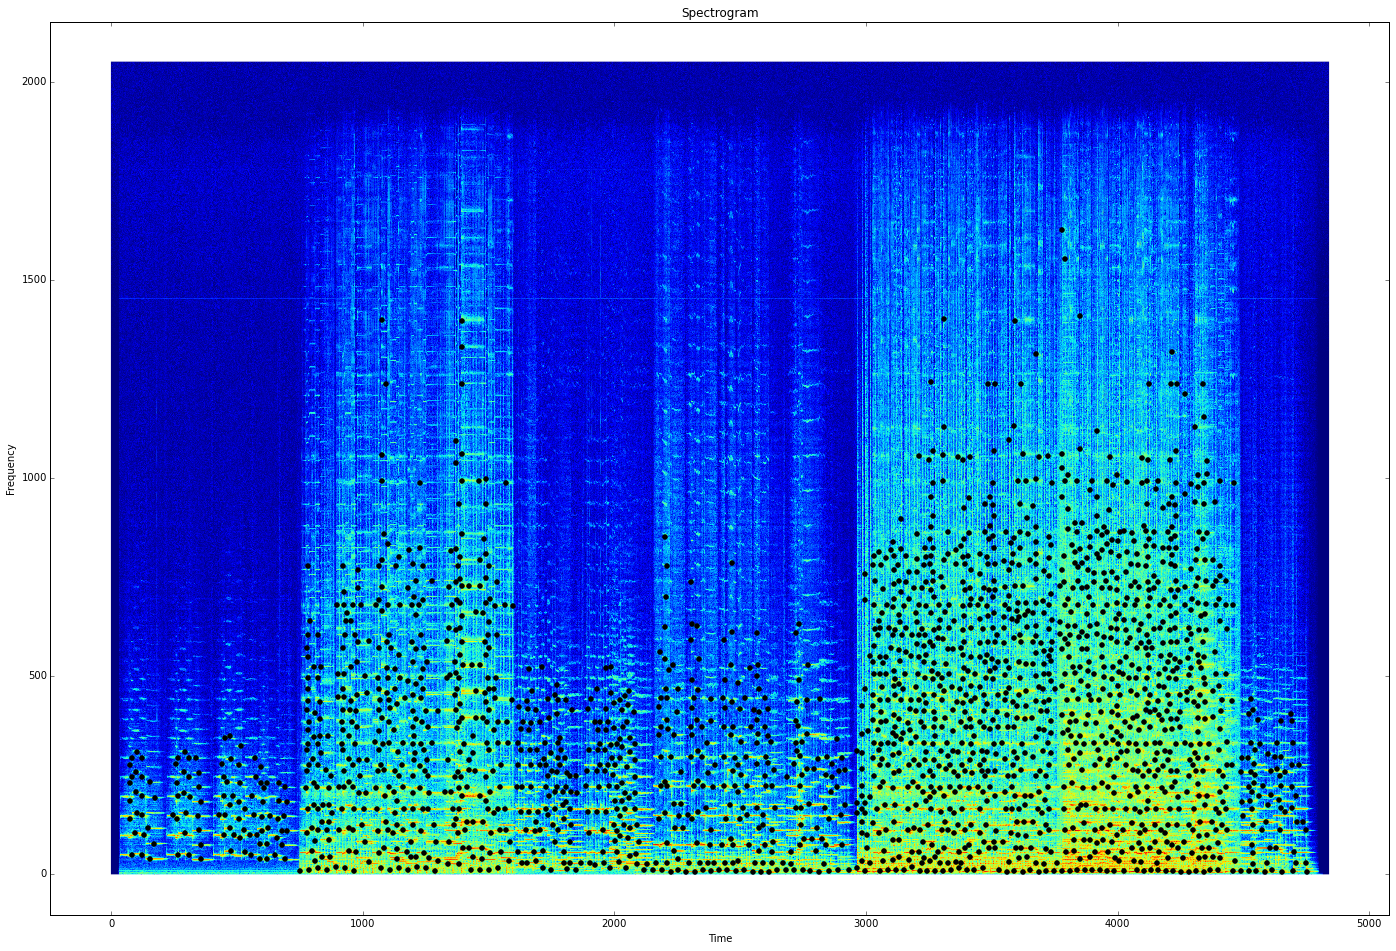

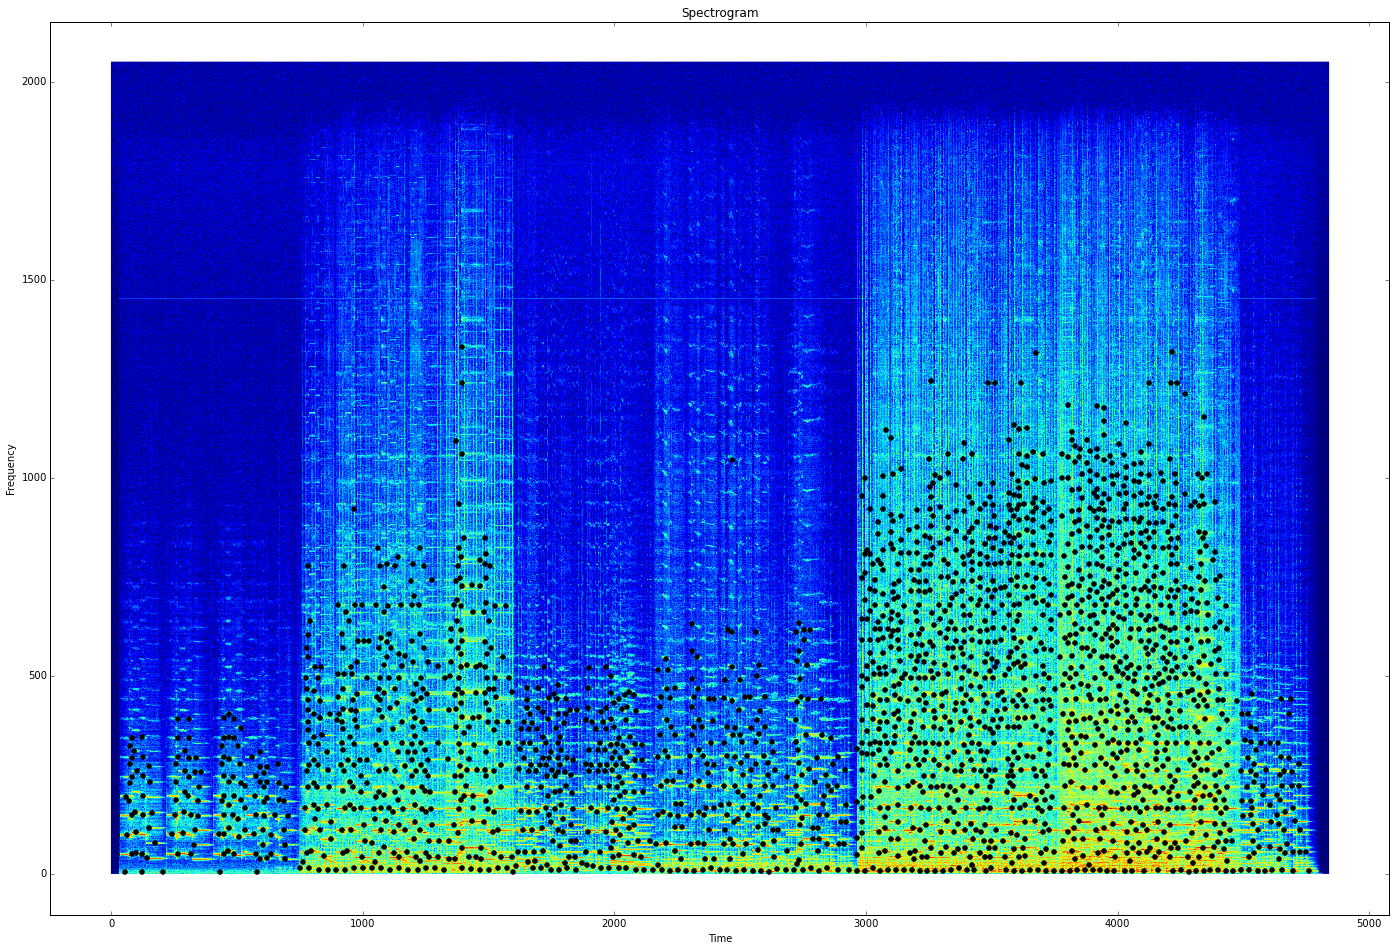

In [8]:
channels, framerate, data = readAudioFile('_originals/01 The Godfather - Waltz.wav')
for samples in channels:
    hashes = fingerprint(samples, plot = True)

Next, we use defaultdict to generate an python dictionary structure that mapping each hash to the list of time corresponding to the hash.

This structure needs to be changed if we want to use OpenCL to parallelize the search. For parallelism, the data structure is instead lists of tuples [(hash, t1),  (hash, t2), (hash, t3), ...]

In [6]:
# for serial: dictionary {'hash': [t1, t2, t3, ...]}
from collections import defaultdict
def hashesToDict(hashesExcerpt):
    dataExcerpt  = []
    for i in hashesExcerpt:
        dataExcerpt.append(i)
    dictExcerpt = defaultdict(list)
    for hashString, t1 in dataExcerpt:
        dictExcerpt[hashString].append(t1)
    #print dictExcerpt
    return dictExcerpt

# for parallel: [(hash, t1),  (hash, t2), (hash, t3), ...]
def hashesToDictParallel(hashesExcerpt):
    return list(hashesExcerpt)

##Loading the database##

**This needs to be run only once everytime the notebook is opened**
Here we set the system directory.
- **fingerprintdir**: fingerprints folder
- **original**: database folder with full soundtracks
- **excerptdir**: folder with excerpts directly cut from soundtracks
- **querydir**: folder with recorded snippets (we tested both 5s and 10s snippets, so two subfolders exist)

In [24]:
# Set The system Directory, Need to run whenever new stuff is added to those files
import glob
import os

fingerprintdir = '_fingerprints/'
songsdir = '_originals/'
excerptdir = '_excerpts/'
querydir_5s = '_recordings/5s/'
querydir_10s = '_recordings/10s/'

# extract the file names in each of the folders
originals = glob.glob(songsdir + '*.wav')

if not os.path.exists(fingerprintdir):
    os.makedirs(fingerprintdir)
if not os.path.exists(excerptdir):
    os.makedirs(excerptdir)
if not os.path.exists(querydir_5s):
    os.makedirs(querydir_5s)
if not os.path.exists(querydir_10s):
    os.makedirs(querydir_10s)

recordings_5s = glob.glob(querydir_5s + '*.wav')
recordings_10s = glob.glob(querydir_10s + '*.wav')
excerpts = glob.glob(excerptdir +'*.wav')

##Cutting excerpts from original soundtracks##

In [9]:
def cutAudioFile(filename, distname, lowLimit, highLimit):
    audiofile = AudioSegment.from_wav(filename)
    audiofile = audiofile[:highLimit*1000]
    audiofile = audiofile[lowLimit*1000:]
    audiofile.export(distname,format = 'wav')
    
def makeExcerpt():
    numBins = 200
    count_correct = 0
    delta_k3_max = 0
    total=0
    runTime = []
    for song in originals:
        #print query
        excerptName = os.path.split(os.path.splitext(song)[0])[1]  # a string storing the name of the query song
        dist = excerptdir+excerptName+'.wav'
        cutAudioFile(song,dist,45,50)

In [10]:
makeExcerpt()

##Play and record snippets##

We will play each soundtrack in the database and record one 5 second snippet and one 10 second snippet. This is a manual process which we have done. **There is no need to run this code.**

In [11]:
# Record Excerpt
'''import pyaudio
import wave
def record(RECORD_SECONDS,filename):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    #RECORD_SECONDS = 5
    WAVE_OUTPUT_FILENAME = filename+".wav"
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    print("* recording")
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("* done recording")
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()'''

'import pyaudio\nimport wave\ndef record(RECORD_SECONDS,filename):\n    CHUNK = 1024\n    FORMAT = pyaudio.paInt16\n    CHANNELS = 2\n    RATE = 44100\n    #RECORD_SECONDS = 5\n    WAVE_OUTPUT_FILENAME = filename+".wav"\n    p = pyaudio.PyAudio()\n    stream = p.open(format=FORMAT,\n                    channels=CHANNELS,\n                    rate=RATE,\n                    input=True,\n                    frames_per_buffer=CHUNK)\n    print("* recording")\n    frames = []\n    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):\n        data = stream.read(CHUNK)\n        frames.append(data)\n    print("* done recording")\n    stream.stop_stream()\n    stream.close()\n    p.terminate()\n    wf = wave.open(WAVE_OUTPUT_FILENAME, \'wb\')\n    wf.setnchannels(CHANNELS)\n    wf.setsampwidth(p.get_sample_size(FORMAT))\n    wf.setframerate(RATE)\n    wf.writeframes(b\'\'.join(frames))\n    wf.close()'

In [12]:
'''filename = '18'
record(10,filename)'''

"filename = '18'\nrecord(10,filename)"

##Creating fingerprints in serial##

Here we use the functions defined above to convert original soundtracks to fingerprints, whos structure is later used for the serial version of the code.

In [13]:
# Read Data in the Original Way(serial way). This way stores a dictionary with structure {'someHashKeyWith25BitLong':[t1,t2...]...}
def readDataOld(song_):
    print song_
    song_name = os.path.split(os.path.splitext(song_)[0])[1]  # a string storing the name of the song
    channels, framerate, data = readAudioFile(song_)
    for samples in channels:
        hashes = fingerprint(samples)
    dictOriginal = hashesToDict(hashes)
    fileHandle  = open(fingerprintdir + song_name + ".fp", "wb") #wb: write binary
    pickle.dump(dictOriginal, fileHandle)

#####Running fingerprint creating in serial####

In [98]:
%%time
for soundtrack in originals:
    readDataOld(soundtrack)

_originals/01 The Godfather - Waltz.wav
_originals/02 Love Theme from _The Godfather_.wav
_originals/03 Sicilian Pastorale.wav
_originals/04 The Pick-Up.wav
_originals/05 The Godfather - Tarantella.wav
_originals/06 The Godfather - Mazurka.wav
_originals/07 The Godfather - Finale.wav
_originals/08 The Immigrant.wav
_originals/09 Kay.wav
_originals/10 Marcia Stilo Italiano.wav
_originals/11 The Godfather, Part II - The End Title.wav
_originals/12 Marcia Religiosa.wav
_originals/13 Marica Festa.wav
_originals/14 The Immigrant _ Love Theme.wav
_originals/15 The Godfather, Part III - The Intermezzo.wav
_originals/16 Preludio from Cavalleria Rusticana.wav
_originals/17 Coda - The Godfather, Part III Finale.wav
_originals/18 Cong Cong Na Nian.wav
CPU times: user 10min 43s, sys: 17.8 s, total: 11min 1s
Wall time: 11min 6s


######Using multiprocessing to run the same code##### 

In [14]:
import multiprocessing
def mp_handler():
    jobs = [(soundtrack) for soundtrack in originals]
    print jobs
    p = multiprocessing.Pool(4)
    p.map(readDataOld, originals)

In [100]:
%%time
if __name__ == '__main__':
    mp_handler()

['_originals/01 The Godfather - Waltz.wav', '_originals/02 Love Theme from _The Godfather_.wav', '_originals/03 Sicilian Pastorale.wav', '_originals/04 The Pick-Up.wav', '_originals/05 The Godfather - Tarantella.wav', '_originals/06 The Godfather - Mazurka.wav', '_originals/07 The Godfather - Finale.wav', '_originals/08 The Immigrant.wav', '_originals/09 Kay.wav', '_originals/10 Marcia Stilo Italiano.wav', '_originals/11 The Godfather, Part II - The End Title.wav', '_originals/12 Marcia Religiosa.wav', '_originals/13 Marica Festa.wav', '_originals/14 The Immigrant _ Love Theme.wav', '_originals/15 The Godfather, Part III - The Intermezzo.wav', '_originals/16 Preludio from Cavalleria Rusticana.wav', '_originals/17 Coda - The Godfather, Part III Finale.wav', '_originals/18 Cong Cong Na Nian.wav']
CPU times: user 958 ms, sys: 341 ms, total: 1.3 s
Wall time: 5min 9s
_originals/01 The Godfather - Waltz.wav
_originals/05 The Godfather - Tarantella.wav
_originals/03 Sicilian Pastorale.wav
_or

##### htop ####
I used the htop tool to confirm that the program is indeed running with multi-processing.

<img src="files/htop.png"/>


##Creating fingerprints for OpenCL#

OpenCL requires fixed length arrays, and the **readDataNew** is a function reads data and store in .fphash, .fptime files, two lists of equal length. The hash and t of the same index represents the (hash, t1) relationship.

In [15]:
def readDataNew(song_):
    print song_
    # a string storing the name of the song
    song_name = os.path.split(os.path.splitext(song_)[0])[1]  
    channels, framerate, data = readAudioFile(song_)
    for samples in channels:
        hashes = fingerprint(samples)
    lstOriginal = hashesToDictParallel(hashes)

    hashLst = [i[0] for i in lstOriginal]
    hashLstInt = [np.int32(hash(i)) for i in hashLst]
    timeLst = [np.int32(i[1]) for i in lstOriginal]
    #wb: write binary
    fileHandle  = open(fingerprintdir + song_name + ".fphash", "wb") 
    # Store the hash list
    pickle.dump(hashLstInt, fileHandle)
    fileHandle.close()
    # Store the time list
    TimeHandle = open(fingerprintdir + song_name + ".fptime", "wb")
    pickle.dump(timeLst, TimeHandle)

######Create fingerprints for OpenCL in serial#####

In [102]:
%%time
for soundtrack in originals:
    readDataNew(soundtrack)

_originals/01 The Godfather - Waltz.wav
_originals/02 Love Theme from _The Godfather_.wav
_originals/03 Sicilian Pastorale.wav
_originals/04 The Pick-Up.wav
_originals/05 The Godfather - Tarantella.wav
_originals/06 The Godfather - Mazurka.wav
_originals/07 The Godfather - Finale.wav
_originals/08 The Immigrant.wav
_originals/09 Kay.wav
_originals/10 Marcia Stilo Italiano.wav
_originals/11 The Godfather, Part II - The End Title.wav
_originals/12 Marcia Religiosa.wav
_originals/13 Marica Festa.wav
_originals/14 The Immigrant _ Love Theme.wav
_originals/15 The Godfather, Part III - The Intermezzo.wav
_originals/16 Preludio from Cavalleria Rusticana.wav
_originals/17 Coda - The Godfather, Part III Finale.wav
_originals/18 Cong Cong Na Nian.wav
CPU times: user 10min 45s, sys: 17.4 s, total: 11min 2s
Wall time: 11min 8s


######Create fingerprints for OpenCL using multiprocessing#####

In [16]:
def mp_handler():
    p = multiprocessing.Pool(4)
    p.map(readDataNew, originals)

In [104]:
%%time
if __name__ == '__main__':
    mp_handler()

CPU times: user 1.13 s, sys: 429 ms, total: 1.56 s
Wall time: 5min 18s
_originals/03 Sicilian Pastorale.wav
_originals/01 The Godfather - Waltz.wav
_originals/05 The Godfather - Tarantella.wav
_originals/07 The Godfather - Finale.wav
_originals/04 The Pick-Up.wav_originals/02 Love Theme from _The Godfather_.wav_originals/06 The Godfather - Mazurka.wav_originals/08 The Immigrant.wav



_originals/09 Kay.wav_originals/13 Marica Festa.wav_originals/11 The Godfather, Part II - The End Title.wav_originals/15 The Godfather, Part III - The Intermezzo.wav



_originals/10 Marcia Stilo Italiano.wav_originals/14 The Immigrant _ Love Theme.wav_originals/12 Marcia Religiosa.wav_originals/16 Preludio from Cavalleria Rusticana.wav



_originals/17 Coda - The Godfather, Part III Finale.wav
_originals/18 Cong Cong Na Nian.wav


##Matching in serial##

The serial code is quite optimized and already very efficient. It utilizes the Python dictionary structure.

In [17]:
def match_fingerprint(dictExcerpt,dictOriginal):
    count  = 0
    delta_k = []
    for i in dictExcerpt.keys():
        if i in dictOriginal.keys():
            count+=1
            for j in dictExcerpt[i]:
                for k in dictOriginal[i]:
                    delta_k.append(k-j)
    return count, delta_k

#####Matching the excerpts#####

This is the wrapper that we use to call previously defined functions to each of the excerpts to an original sound track. We first loop through all the excerpt/recording fingerprints, which is small enough to store in the local memory, and then compare it to the pre-made fingerprints of the original soundtracks.

Initially written in 4 functions for excerpts/recordings + serial/parallel, we consolidateed them into a single function that takes in the type of snippets and whether it is parallelized. The OpenCL part of the parallelization will be shown in the next section, and here we only include the driver.

Note that here we account for the different data structure between the serial and parallelized version- fingerprint.fp is passed into serial with [hash, [list of t]] format, whereas equal-length fingerprint.hash and fingerprint.fpime are passed into parallel.

In [2]:
def findMatch(excerpts, parallel):
    numBins = 200
    count_correct = 0
    delta_k3_max = 0
    total=0
    runTime = []
    timePrepare = []
    #print songs_excerpt
    for excerpt in excerpts:
    #print excerpt
        # a string storing the name of the excerpt song
        excerpt_name = os.path.split(os.path.splitext(excerpt)[0])[1]
        #print excerpt_name
        channelsExcerpt3, framerate, data = readAudioFile(excerpt)
        #print channelsExcerpt3
        
        for samples in channelsExcerpt3:
            hashesExcerpt3 = fingerprint(samples)
            
        if parallel:
            #compile the list of .fphash and .fptime to be passed into the driver
            lstExcerpt3 = hashesToDictParallel(hashesExcerpt3)
            hashLstIntExcerpt3 = [np.int32(hash(i[0])) for i in lstExcerpt3]
            timeLstExcerpt3 = [np.int32(i[1]) for i in lstExcerpt3]
            fingerprintHashLst = glob.glob(fingerprintdir + '*.fphash')
            fingerprintTimeLst = glob.glob(fingerprintdir + '*.fptime')
            #print fingerprintHashLst
            #print fingerprintTimeLst
            
            match_dictionary = types.DictType.__new__(types.DictType, (), {})
            
            for (fphash,fptime) in zip(fingerprintHashLst,fingerprintTimeLst):
            #print fphash
                fhash_name = os.path.split(os.path.splitext(fphash)[0])[1]
                ftime_name = os.path.split(os.path.splitext(fptime)[0])[1]
                fileHandleHash = open(fphash,"rb")
                lstHashOriginal = pickle.load(fileHandleHash)
                fileHandleHash.close()
                fileHandleTime = open(fptime,"rb")
                lstTimeOriginal = pickle.load(fileHandleTime)
                fileHandleTime.close()
                #pass lists into OpenCL
                a = cl.array.to_device(queue, np.array(hashLstIntExcerpt3, dtype=np.uint32))
                b = cl.array.to_device(queue,np.array(timeLstExcerpt3, dtype=np.int32))
                d = cl.array.to_device(queue, np.array(lstHashOriginal, dtype=np.uint32))
                e = cl.array.to_device(queue,np.array(lstTimeOriginal,dtype=np.int32))
                c = cl.array.empty(queue,200,dtype = np.int64)
                #initialize the counter
                c.fill(0)
                start = time.time()
                #call the findsong function in .cl
                find_song(queue, (len(d),),None, a.data, b.data, c.data, d.data, e.data,np.int32(len(b)),np.int32(len(e)),np.int32(-1000),np.int32(5000), np.uint32(30))
                runTime.append(time.time()-start)
                match_dictionary[fhash_name]=max(c.get())
           
        else:
            dictExcerpt3 = hashesToDict(hashesExcerpt3)
            fingerprints = glob.glob(fingerprintdir + '*.fp')
            #print fingerprints
            
            match_dictionary = types.DictType.__new__(types.DictType, (), {})
        
        
            for fp in fingerprints:
                f_name = os.path.split(os.path.splitext(fp)[0])[1]
                fileHandle = open(fp,"rb")
                dictOriginal = pickle.load(fileHandle)
                start = time.time()
                count, delta_k3 = match_fingerprint(dictExcerpt3,dictOriginal)
                runTime.append(time.time()-start)
                #print max(delta_k3),min(delta_k3)
                #print delta_k3
                if delta_k3:
                    hist,bin_edges = np.histogram(delta_k3, numBins)
                    #print hist
                    delta_k3_max = np.amax(hist)
                    match_dictionary[f_name]=delta_k3_max
                    #fig = plt.figure()
                    #ax = fig.add_subplot(111)
                    #numBins = 200
                    #ax.hist(delta_k3,numBins,color='green',alpha=0.8)
                
        match_value=max(match_dictionary.values())
        
        #print match_dictionary
        for name in match_dictionary.iterkeys():
            if match_value == match_dictionary[name]:
                found_name = name
        s = difflib.SequenceMatcher(None, excerpt_name, found_name)
        if difflib.get_close_matches(excerpt_name,found_name)!=[]:
            count_correct+=1
        elif s.real_quick_ratio()>=0.9:
            count_correct+=1
        total+=1
        print "sample_name = %s, original_name = %s,"%(excerpt_name,found_name)
    print 'running time = ', sum(runTime)

    print "\naccuracy = %f%s" % (count_correct/float(total)*100,"percent")

In [22]:
%%time
findMatch(excerpts, parallel=0)

sample_name = 01 The Godfather - Waltz, original_name = 01 The Godfather - Waltz,
sample_name = 02 Love Theme from _The Godfather_, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03 Sicilian Pastorale, original_name = 03 Sicilian Pastorale,
sample_name = 04 The Pick-Up, original_name = 04 The Pick-Up,
sample_name = 05 The Godfather - Tarantella, original_name = 05 The Godfather - Tarantella,
sample_name = 06 The Godfather - Mazurka, original_name = 06 The Godfather - Mazurka,
sample_name = 07 The Godfather - Finale, original_name = 07 The Godfather - Finale,
sample_name = 08 The Immigrant, original_name = 08 The Immigrant,
sample_name = 09 Kay, original_name = 09 Kay,
sample_name = 10 Marcia Stilo Italiano, original_name = 10 Marcia Stilo Italiano,
sample_name = 11 The Godfather, Part II - The End Title, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 12 Marcia Religiosa, original_name = 12 Marcia Religiosa,
sample_name = 13 Marica Festa, ori

######Matching the recordings in serial#####

In [23]:
%%time
findMatch(recordings_5s, parallel=0)

sample_name = 01, original_name = 01 The Godfather - Waltz,
sample_name = 02, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03, original_name = 12 Marcia Religiosa,
sample_name = 04, original_name = 04 The Pick-Up,
sample_name = 05, original_name = 18 Cong Cong Na Nian,
sample_name = 06, original_name = 06 The Godfather - Mazurka,
sample_name = 07, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 08, original_name = 08 The Immigrant,
sample_name = 09, original_name = 16 Preludio from Cavalleria Rusticana,
sample_name = 10, original_name = 10 Marcia Stilo Italiano,
sample_name = 11, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 12, original_name = 12 Marcia Religiosa,
sample_name = 13, original_name = 13 Marica Festa,
sample_name = 14, original_name = 14 The Immigrant _ Love Theme,
sample_name = 15, original_name = 08 The Immigrant,
sample_name = 16, original_name = 12 Marcia Religiosa,
sample_name = 17, original_nam

In [25]:
%%time
findMatch(recordings_10s, parallel=0)

sample_name = 01, original_name = 01 The Godfather - Waltz,
sample_name = 02, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03, original_name = 10 Marcia Stilo Italiano,
sample_name = 04, original_name = 04 The Pick-Up,
sample_name = 05, original_name = 07 The Godfather - Finale,
sample_name = 06, original_name = 06 The Godfather - Mazurka,
sample_name = 07, original_name = 16 Preludio from Cavalleria Rusticana,
sample_name = 08, original_name = 08 The Immigrant,
sample_name = 09, original_name = 09 Kay,
sample_name = 10, original_name = 10 Marcia Stilo Italiano,
sample_name = 11, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 12, original_name = 12 Marcia Religiosa,
sample_name = 13, original_name = 13 Marica Festa,
sample_name = 14, original_name = 14 The Immigrant _ Love Theme,
sample_name = 15, original_name = 15 The Godfather, Part III - The Intermezzo,
sample_name = 16, original_name = 16 Preludio from Cavalleria Rusticana,
sample_nam

##Matching in parallel##

Now, we are ready to explore OpenCL and parallelize the matching part.

In [26]:
from __future__ import division
import numpy as np
import pyopencl as cl
import pyopencl.array

In [27]:
%load_ext pyopencl.ipython_ext

When prompted with choices, just hit enter to use the default.

In [28]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Apple' at 0x7fff0000>
Choice [0]:
Choose device(s):
[0] <pyopencl.Device 'Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz' on 'Apple' at 0xffffffff>
[1] <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>
Choice, comma-separated [0]:
Set the environment variable PYOPENCL_CTX=':' to avoid being asked again.


**Parallelism using OpenCL to construct a 'histogram' counter**

In [37]:
%%cl_kernel
__kernel void find_song(__global const int *a, __global const int *b, 
__global long *c,
__global const int *d, __global const int *e, int n, const unsigned int size, const int min, const int max, const int binSize)
{
  const size_t gid = get_global_id(0);
  const size_t lid = get_local_id(0);
  if (1)
{
  for (int i = 0; i < n; i++)
    {
            
        if (a[i] == d[gid])
        {
             int x = b[i] - e[gid];
             if (x<max && x>min)
            {
                int idx = (x-min)/binSize;
                if (idx > size)
                {
                 continue;        
                }
                c[idx]+=1;
            }
        }
    }
  
  }
}

The following cell reads data in a multi-processing way

Parallel in multi-process read data for OpenCL

In [32]:
%%time
findMatch(excerpts, parallel=1)

sample_name = 01 The Godfather - Waltz, original_name = 01 The Godfather - Waltz,
sample_name = 02 Love Theme from _The Godfather_, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03 Sicilian Pastorale, original_name = 03 Sicilian Pastorale,
sample_name = 04 The Pick-Up, original_name = 04 The Pick-Up,
sample_name = 05 The Godfather - Tarantella, original_name = 05 The Godfather - Tarantella,
sample_name = 06 The Godfather - Mazurka, original_name = 06 The Godfather - Mazurka,
sample_name = 07 The Godfather - Finale, original_name = 07 The Godfather - Finale,
sample_name = 08 The Immigrant, original_name = 08 The Immigrant,
sample_name = 09 Kay, original_name = 09 Kay,
sample_name = 10 Marcia Stilo Italiano, original_name = 10 Marcia Stilo Italiano,
sample_name = 11 The Godfather, Part II - The End Title, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 12 Marcia Religiosa, original_name = 12 Marcia Religiosa,
sample_name = 13 Marica Festa, ori

In [33]:
%%time
findMatch(recordings_5s, parallel=1)

sample_name = 01, original_name = 01 The Godfather - Waltz,
sample_name = 02, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03, original_name = 03 Sicilian Pastorale,
sample_name = 04, original_name = 04 The Pick-Up,
sample_name = 05, original_name = 12 Marcia Religiosa,
sample_name = 06, original_name = 06 The Godfather - Mazurka,
sample_name = 07, original_name = 07 The Godfather - Finale,
sample_name = 08, original_name = 08 The Immigrant,
sample_name = 09, original_name = 10 Marcia Stilo Italiano,
sample_name = 10, original_name = 10 Marcia Stilo Italiano,
sample_name = 11, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 12, original_name = 10 Marcia Stilo Italiano,
sample_name = 13, original_name = 13 Marica Festa,
sample_name = 14, original_name = 14 The Immigrant _ Love Theme,
sample_name = 15, original_name = 06 The Godfather - Mazurka,
sample_name = 16, original_name = 13 Marica Festa,
sample_name = 17, original_name = 04 The Pick-U

In [34]:
%%time
findMatch(recordings_10s, parallel=1)

sample_name = 01, original_name = 01 The Godfather - Waltz,
sample_name = 02, original_name = 02 Love Theme from _The Godfather_,
sample_name = 03, original_name = 10 Marcia Stilo Italiano,
sample_name = 04, original_name = 04 The Pick-Up,
sample_name = 05, original_name = 05 The Godfather - Tarantella,
sample_name = 06, original_name = 06 The Godfather - Mazurka,
sample_name = 07, original_name = 11 The Godfather, Part II - The End Title,
sample_name = 08, original_name = 08 The Immigrant,
sample_name = 09, original_name = 09 Kay,
sample_name = 10, original_name = 10 Marcia Stilo Italiano,
sample_name = 11, original_name = 08 The Immigrant,
sample_name = 12, original_name = 12 Marcia Religiosa,
sample_name = 13, original_name = 13 Marica Festa,
sample_name = 14, original_name = 14 The Immigrant _ Love Theme,
sample_name = 15, original_name = 15 The Godfather, Part III - The Intermezzo,
sample_name = 16, original_name = 12 Marcia Religiosa,
sample_name = 17, original_name = 13 Marica F